# Purchase Price Prediction

We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?

2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?

3. Help us understand how the price is predicted (again, a few sentences will suffice).

-------------------

## Table of Content

### 1. Prepare Data Set

   - Input Python Packages
   - Load and Prepare Data Set

### 2. Data Quality Assessment

   - Check Missing Values
   - Check Duplicated Values
   
### 3. Exploratory Data Analysis and Feature Engineering

   - please input
   - please input
   
### 4. Building Models

   - please input
   - please input
   
### 5. Conclusion

   - please input
   - please input
   
### 6. Reference



--------------------

## 1. Prepare Data Set

### Input Python Packages

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler 
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer

### Load and Prepare Data Set

In [2]:
df = pd.read_csv('sales.csv')

In [3]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2216 non-null   object
 1   price          3186 non-null   object
 2   weight         3193 non-null   object
 3   purchase_date  3196 non-null   object
 4   product_type   3196 non-null   object
 5   product_level  3196 non-null   object
 6   maker          2373 non-null   object
 7   ingredient     2941 non-null   object
 8   height         3197 non-null   object
 9   width          3193 non-null   object
 10  depth          3193 non-null   object
dtypes: object(11)
memory usage: 274.9+ KB


In [5]:
df.describe()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2216,3186,3193,3196,3196,3196,2373,2941,3197,3193,3193
unique,185,3157,119,1278,64,5,882,2833,161,41,13
top,$66k,"$262,119",3 Ton 0 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,127,8,485,1323,17,8,63,268,903


## 2. Data Quality Assesment

### Check Missing Values

In [6]:
# check and sort out the percentage of missing values on each column
(df.isnull().sum()*100/len(df)).round(2).sort_values(ascending=False)

cost             30.69
maker            25.77
ingredient        8.01
price             0.34
weight            0.13
width             0.13
depth             0.13
purchase_date     0.03
product_type      0.03
product_level     0.03
height            0.00
dtype: float64

#### Note: We have more than 20% of missing values on *cost* and *maker* features.

**Price** will be our predict target for modeling, and there are only 0.34% of missing values on price column, so I will use dropna to remove null values on price. 

In [7]:
df.dropna(subset=['price'], inplace=True)

### Check Duplicated Values

In [8]:
df.duplicated().sum()

0

## 3. Exploratory Data Analysis and Feature Engineering

### Numerical Data Analysis

In [9]:
# Write functions tranform string values to numerical values

def cost2num(x):
    if type(x) == str: 
        x = x.strip('$').strip('k')
        return float(x)*1000
    else:
        return x

def weight2num(x):
    if type(x) == str:
        x = x.strip("Kg").replace(" ", "").split("Ton")
        return float(x[0])*1000 + float(x[1])
    else:
        return x

def height2num(x):
    if type(x) == str: 
        x = x.strip(' meters')
        return float(x)
    else:
        return x

def width2num(x):
    if type(x) == str: 
        x = x.strip(' cm')
        return float(x)
    else:
        return x

def depth2num(x):
    if type(x) == str: 
        x = x.strip(' cm')
        return float(x)
    else:
        return x

def price2num(price):
    if type(price)==str:
        price = price.strip('$').replace(',', '')
    return float(price)

In [10]:
# Add new columns for cost, price, weight, height, width, depth and map the functions
df['cost($)'] = df['cost'].map(cost2num)
df['price($)'] = df['price'].map(price2num)
df['weight(kg)'] = df['weight'].map(weight2num)
df['height(meters)'] = df['height'].map(height2num)
df['width(cm)'] = df['width'].map(width2num)
df['depth(cm)'] = df['depth'].map(depth2num)

In [11]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,cost($),price($),weight(kg),height(meters),width(cm),depth(cm)
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm,333000.0,300492.0,3090.0,2.76,97.0,26.0
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm,NaN,430570.0,3030.0,2.67,98.0,26.0
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm,270000.0,213070.0,3040.0,3.00,93.0,24.0
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm,NaN,229174.0,3050.0,2.50,102.0,27.0
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm,97000.0,122659.0,2970.0,2.47,101.0,26.0


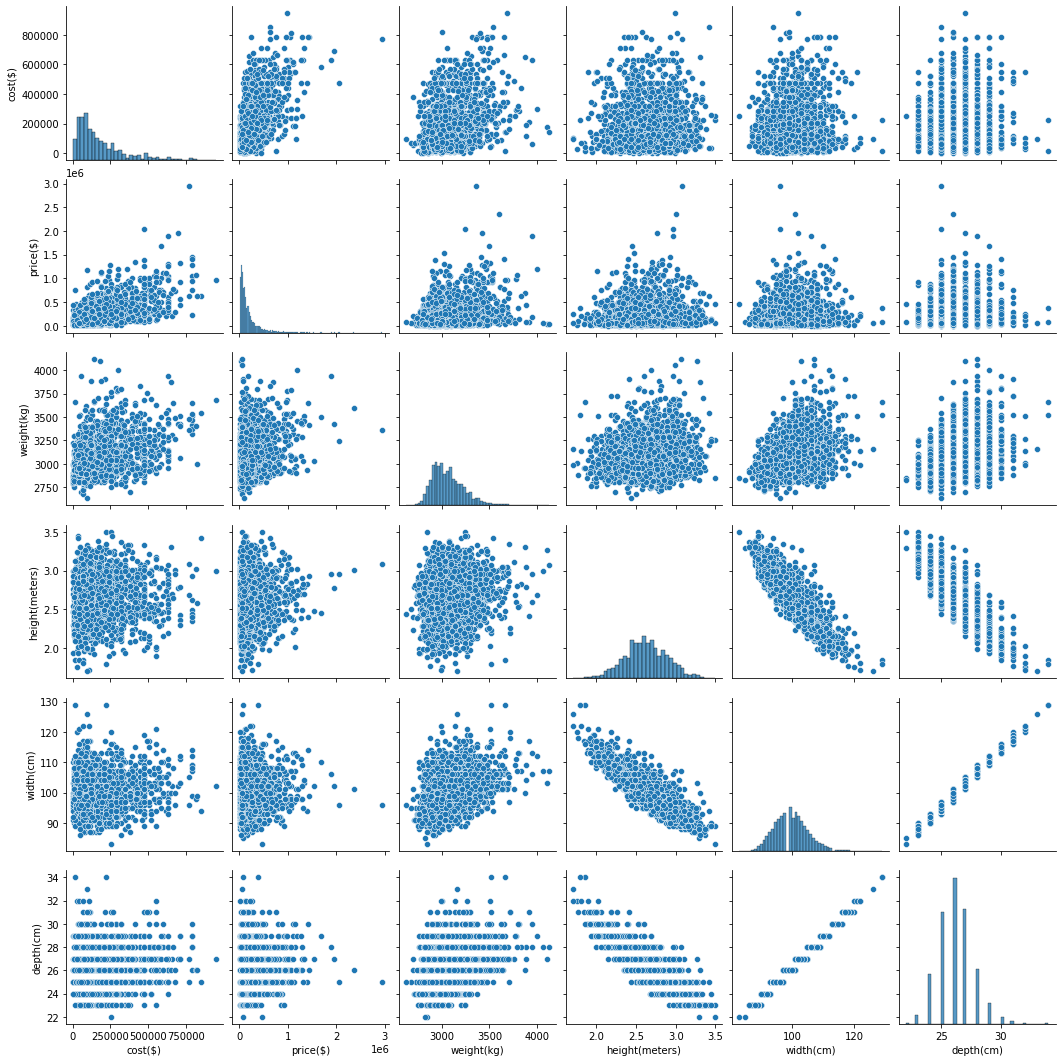

In [12]:
# Plot the distribution of numerical features
sns.pairplot(df)

#### Observations:

1. cost, price are highly **right-skewed**. It means they have outliers on the right side of distribution. May consider doing log transform to remove the skewness. 
2. **Correlation**:

   - Highly correlated: width vs depth

   - Highly negative-correlated: height vs width, height vs depth

   - Reasonably correlated: price vs cost

#### Check Pearson correlation coefficient to prove if price and cost has high correlation

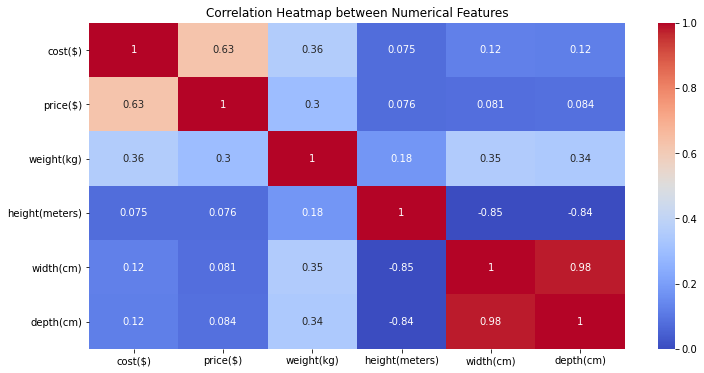

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Numerical Features')
plt.show()

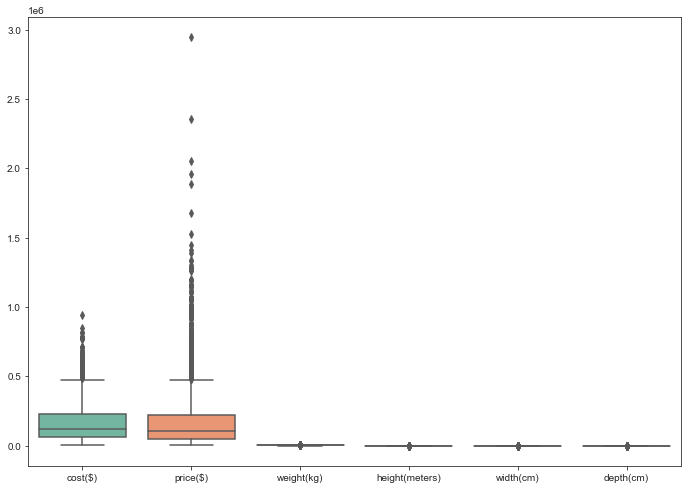

In [14]:
# plot the outliers
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(data=df, palette="Set2")

In [15]:
# Add columns for year, month
df['year'] = pd.to_datetime(df.purchase_date).dt.year
df['month'] = pd.to_datetime(df.purchase_date).dt.strftime('%b')

#### Trend analysis on year over year prices

Text(0.5, 1.0, 'Price Over Years')

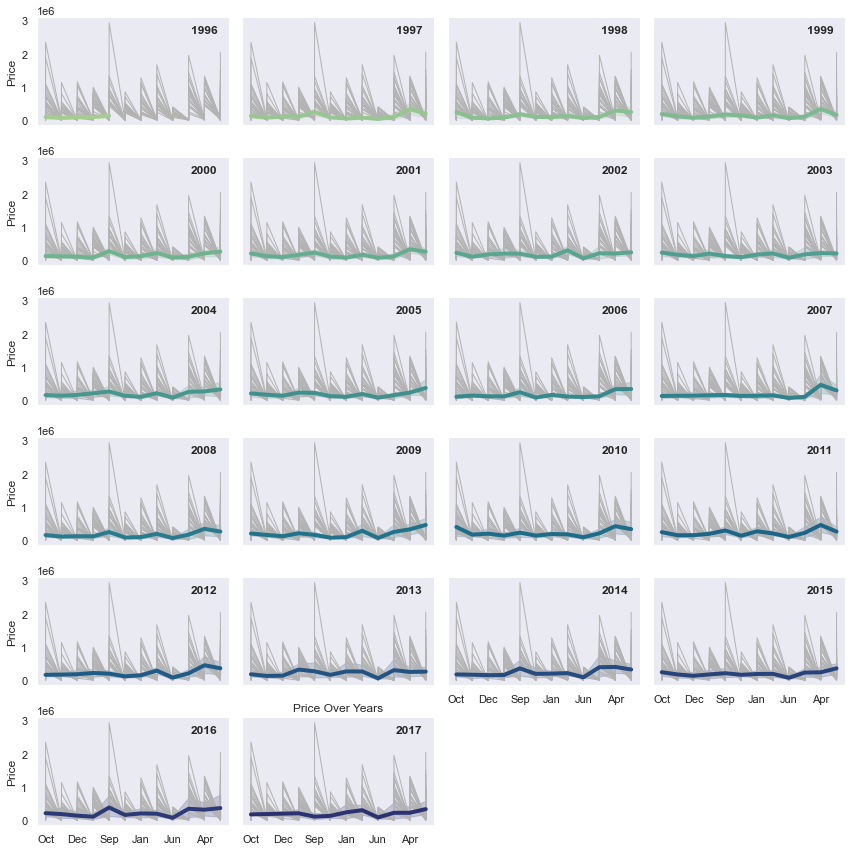

In [16]:
sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df,
    x="month", y="price($)", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=4, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df, x="month", y="price($)", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Price")
g.tight_layout()

plt.title('Price Over Years')

#### Observations:
1. In general, year over year the  purchase prices are pretty flat .
2. Low peak often happened in June, and high peaks of purchase normally in month April and September. 

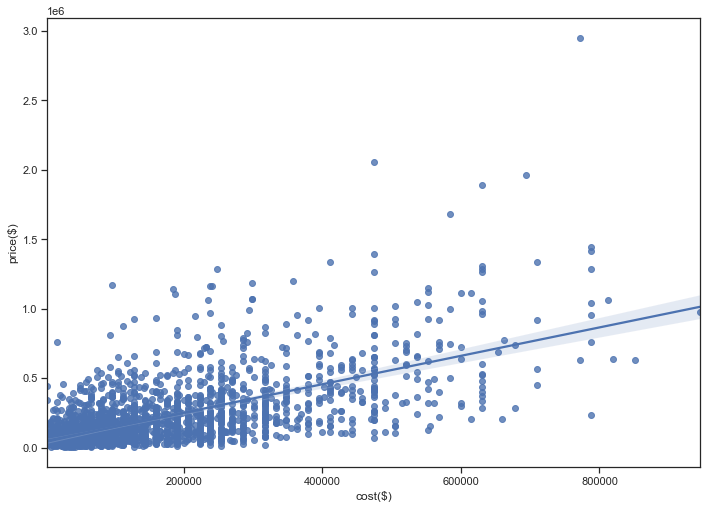

In [17]:
# Plot the relationship between price and cost
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.regplot(x="cost($)", y="price($)", data=df)

#### It shows a linear corelation.

### Categorical Data Analysis

In [18]:
df['product_level'].value_counts()

advanced          1320
super advanced    1222
intermediate       532
basic              111
unrated              1
Name: product_level, dtype: int64

<AxesSubplot:>

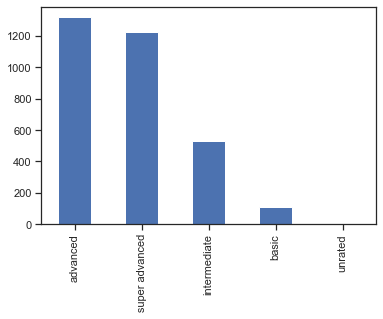

In [19]:
df.product_level.value_counts().plot(kind='bar' )

**Observation**: </font> Many rows of **product_type**, **maker**, and **ingredient** contain multiple categorical values.

In [20]:
# Create a function to count single value on product_type, maker, and ingredient columns
def single_valuecounts(column):
    return column.str.split(',').explode().value_counts()

In [21]:
# Top 10 product_type
single_valuecounts(df['product_type']).sort_values(ascending=False).head(10)

D    1100
H     642
A     500
U     393
N     331
R     245
B     217
C     201
J     196
S     177
Name: product_type, dtype: int64

In [22]:
# Top 10 maker
single_valuecounts(df['maker']).sort_values(ascending=False).head(10)

M14196    17
M14346    16
M14163    15
M14170    15
M14565    14
M14164    13
M14216    12
M14313    12
M14427    12
M14319    11
Name: maker, dtype: int64

In [23]:
# Top 10 ingredient
single_valuecounts(df['ingredient']).sort_values(ascending=False).head(10)

IN732658    64
IN732094    51
IN732489    44
IN732074    42
IN732583    41
IN732505    40
IN732097    39
IN732503    36
IN732231    36
IN732217    34
Name: ingredient, dtype: int64

## 4. Building Models

### Prepare Data for Models

In [24]:
# Transform string to numerical values

class NumricalTransformer(object):
    def __init__(self):
        self.mean = 0
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        df['volumn'] = 100 * df['height'] * df['width'] * df['depth']
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        df['volumn'] = 100 * df['height'] * df['width'] * df['depth']
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x
        
    def weight2num(self, x):
        if type(x) == str: 
            x = x.strip(' Kg').replace(' Ton ', '.')
            return float(x)
        else:
            return x
    
    def height2num(self, x):
        if type(x) == str: 
            x = x.strip(' meters')
            return float(x)
        else:
            return x
    
    def width2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def depth2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x

In [25]:
# Transform categorical values to dummy varibles
class DummyTransformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        res = {}
        for key in self.keys:
            res[key] = [0]*len(X)    
        for i, item in enumerate(X):
            if item in self.keys:
                res[item][i] = 1
        return pd.DataFrame(res)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)  

#### Split data to training & test data set and apply transformers

In [26]:
# print(list(df.columns))
features = ['cost',
             'price($)',
             'weight',
             'purchase_date',
             'product_type',
             'product_level',
             'maker',
             'ingredient',
             'height',
             'width',
             'depth']
target = 'price($)'
features.remove(target)

In [27]:
X, y = df[features], df[target]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2548, 10) (638, 10) (2548,) (638,)


In [29]:
ntf = NumricalTransformer()

In [30]:
dtf = DummyTransformer()

In [31]:
ntf.fit_transform(X_train)

,cost,weight,height,width,depth,volumn
2628,295000.000000,3.78,2.60,111.0,29.0,836940.0
340,169000.000000,3.22,2.55,104.0,27.0,716040.0
2437,176000.000000,3.28,2.36,109.0,28.0,720272.0
869,254000.000000,2.82,2.71,94.0,25.0,636850.0
1719,165160.724392,3.23,2.62,102.0,27.0,721548.0
...,...,...,...,...,...,...
148,165160.724392,2.88,2.70,95.0,25.0,641250.0
965,165160.724392,2.96,2.34,104.0,27.0,657072.0
1839,28000.000000,3.30,2.60,99.0,26.0,669240.0
1736,97000.000000,3.26,2.66,102.0,27.0,732564.0


In [32]:
ntf.transform(X_test).head() 

,cost,weight,height,width,depth,volumn
1310,653000.000000,3.87,3.31,100.0,26.0,860600.0
2768,165160.724392,3.50,2.68,98.0,26.0,682864.0
2924,238000.000000,3.14,2.98,94.0,25.0,700300.0
12,191000.000000,3.20,2.87,97.0,25.0,695975.0
1680,165160.724392,3.29,2.39,108.0,28.0,722736.0


In [33]:
dtf.fit_transform(X_train)

,cost,weight,width,product_level,purchase_date,product_type,ingredient,maker,depth,height
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2543,0,0,0,0,0,0,0,0,0,0
2544,0,0,0,0,0,0,0,0,0,0
2545,0,0,0,0,0,0,0,0,0,0
2546,0,0,0,0,0,0,0,0,0,0


In [34]:
dtf.transform(X_test).head() 

,cost,weight,width,product_level,purchase_date,product_type,ingredient,maker,depth,height
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


#### Apply PCA for dimensionality-reduction

It normally uses in a large data set. I don't think we need to use here(from previous homework, it didn't improve that much for model performance). However for learning purpose, I will use here.

Text(0, 0.5, 'cumulative explained variance')

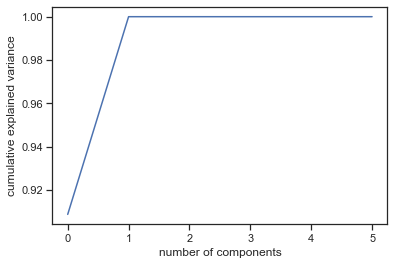

In [35]:
pca_test = PCA().fit(ntf.fit_transform(X_train))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

n_components = 2 will be a good number.

In [36]:
pca = PCA()
X_train_pca = pca.fit_transform(ntf.fit_transform(X_train))

# transfer to df
X_train_df = pd.DataFrame(X_train_pca)
X_train_df.head()

,0,1,2,3,4,5
0,146431.627055,139342.424398,3.630070,0.243386,-0.097248,-0.040464
1,7639.328770,33373.051518,2.446707,0.264062,-0.138900,-0.015897
2,15070.698337,36791.321908,7.329550,0.562725,-0.155325,0.004085
3,83198.403049,-54870.262455,-3.633344,-0.427225,-0.055015,-0.015657
4,4443.570556,39277.730126,0.226211,-0.226677,-0.059808,-0.018871


In [37]:
pca.explained_variance_ratio_

array([9.08676467e-01, 9.13235306e-02, 1.87485790e-09, 5.30443205e-12,
       2.73442576e-12, 6.19998513e-14])

### Apply Machine Learning Models

### Xgboost

In [38]:
from sklearn.pipeline import Pipeline
steps = [('ntf', NumricalTransformer()),
         ('dtf', DummyTransformer()),
         #('Rescale', StandardScaler()),
         #('pca', PCA()),
         ('xgbr', XGBRegressor())]
model = Pipeline(steps)

In [39]:
model.fit(X_train, y_train)

Pipeline(steps=[('ntf', <__main__.NumricalTransformer object at 0x11ef29400>),
                ('dtf', <__main__.DummyTransformer object at 0x11ed950b8>),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=4, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbos

In [40]:
y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

In [41]:
print("\033[1m" + 'Train loss'+ "\033[0m")
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print("\n""\033[1m" + 'Test loss'+ "\033[0m")
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

Train loss
train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.006

Test loss
test MAE: 1.49e+05
test MSE: 5.36e+10
test R2: -0.004


#### Plot the feature importance in a bar chart

Feature: 0, Score: 0.860
Feature: 1, Score: 0.001
Feature: 2, Score: 0.049
Feature: 3, Score: 0.005
Feature: 4, Score: 0.025
Feature: 5, Score: 0.061


([<matplotlib.axis.XTick at 0x122856908>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'height'),
  Text(3, 0, 'width'),
  Text(4, 0, 'depth'),
  Text(5, 0, 'volumn')])

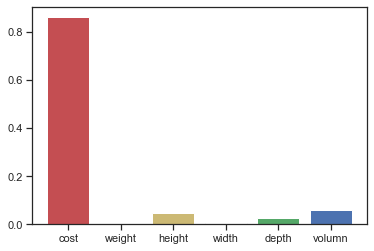

In [43]:
importances = model.steps[2][1].feature_importances_

for i, v in enumerate(importances):
    print('Feature: %0d, Score: %.3f' % (i, v))

plt.bar(range(len(importances)), importances, color=('r', 'c','y', 'k', 'g', 'b'), align = "center")
plt.xticks(range(len(importances)), ['cost', 'weight', 'height', 'width', 'depth', 'volumn'])

#### Tune hyperparameters with k-fold cross validation to optimize model performance

In [44]:
parameters = {'xgbr__gamma': [0.0, 0.1, 0.2, 0.3],
    'xgbr__learning_rate': [0.05, 0.1],
    'xgbr__n_estimators': [100, 300, 500],
    'xgbr__max_depth': [3, 5, 10],
    'xgbr__lambda': [0.5, 1, 5],
    'xgbr__min_child_weight': [3, 5, 7]}

In [45]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [46]:
steps = [('ntf', NumricalTransformer()),
         ('dtf', DummyTransformer()),
         ('Rescale', StandardScaler()),
         #('pca', PCA()),
         ('xgbr', XGBRegressor())]
model = Pipeline(steps)

In [47]:
model_gsv = GridSearchCV(model, parameters, cv = 5, scoring = scorer)

In [48]:
model_gsv = model_gsv.fit(X_train, y_train)

In [49]:
model_gsv.best_params_

{'xgbr__gamma': 0.0,
 'xgbr__lambda': 5,
 'xgbr__learning_rate': 0.1,
 'xgbr__max_depth': 3,
 'xgbr__min_child_weight': 3,
 'xgbr__n_estimators': 100}

In [50]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print("\n""\033[1m" + 'Test loss'+ "\033[0m")
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.006

Test loss
test MAE: 1.49e+05
test MSE: 5.36e+10
test R2: -0.004


### Loop to a series models and check the performance

In [51]:
models = [LinearRegression(), Lasso(), Ridge(alpha = 0.5), RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()]

for model_name in models:
    
    steps = [('ntf', NumricalTransformer()),
             ('dtf', DummyTransformer()),
             ('Rescale', StandardScaler()),
             #('pca', PCA()),
             ('model', model_name)]
    model = Pipeline(steps)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("\n")
    print(model_name)
    print("\n")  
    print("\033[1m" + 'Train loss'+ "\033[0m")
    print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
    print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
    print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
    print("\n""\033[1m" + 'Test loss'+ "\033[0m")
    print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
    print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
    print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
    
        





LinearRegression()


Train loss
train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.006

Test loss
test MAE: 1.49e+05
test MSE: 5.36e+10
test R2: -0.004


Lasso()


Train loss
train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.006

Test loss
test MAE: 1.49e+05
test MSE: 5.36e+10
test R2: -0.004


Ridge(alpha=0.5)


Train loss
train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.006

Test loss
test MAE: 1.49e+05
test MSE: 5.36e+10
test R2: -0.004


RandomForestRegressor()


Train loss
train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.005

Test loss
test MAE: 1.48e+05
test MSE: 5.33e+10
test R2: 0.001


GradientBoostingRegressor()


Train loss
train MAE: 1.39e+05
train MSE: 4.71e+10
train R2: 0.006

Test loss
test MAE: 1.49e+05
test MSE: 5.36e+10
test R2: -0.004


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             lear

#### As for all five algorithms, I will end up taking Xgboost, since this algorithm better than all algorithms in all indicators(MAE, MSE, R2).

### Prices Prediction

In [52]:
# will continue

## 5. Conclusion

## 6. Reference

https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/

https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21
    